In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import geopandas as gpd
import pandas as pd
import sklearn

In [5]:
data_dir = '/Users/jyontika/Desktop/opioid-overdose-models/cook-county/cleaning-cook-county/'
csv_path = os.path.join(data_dir, 'cook_county_gdf_semiannual.csv')
cook_county_gdf = pd.read_csv(csv_path) 

In [6]:
#add in missing 56 tracts
cook_county_gdf['semiannual'].fillna(9999, inplace=True) 
cook_county_gdf['year'].fillna(9999, inplace=True)

In [7]:
cook_county_gdf.loc[cook_county_gdf['year'] == 9999, 'geoid'].nunique() #should be 56

56

In [8]:
columns_to_keep = ['STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry']

gdf_semi = cook_county_gdf.groupby(['geoid', 'semiannual', 'year']).agg({'deaths': 'sum', **{col: 'first' for col in columns_to_keep}}).reset_index()

### Making DF square - one "semi-annual" period for each tract

In [9]:
gdf_semi.loc[gdf_semi['year'] == 9999, 'deaths'] = 0
gdf_semi.loc[gdf_semi['semiannual'] == 9999, 'deaths'] = 0

# Replace 9999 with 2015 in the 'year' column
gdf_semi['year'].replace(9999, 2015, inplace=True)
gdf_semi['semiannual'].replace(9999, 1, inplace=True)

In [24]:
gdf_semi['geoid'].nunique()  #should be 1332

1332

In [11]:
##nested for loops
years = range(2015, 2024)
periods = [1, 2]

existing_combinations = set(zip(gdf_semi['geoid'], gdf_semi['year'], gdf_semi['semiannual']))
updated_rows = []

for tract in gdf_semi['geoid'].unique():
    for year in years:
        for period in periods:
            combination = (tract, year, period)
            if combination not in existing_combinations:
                new_row = {'geoid': tract, 'year': year, 'semiannual': period, 'deaths': 0}
                updated_rows.append(new_row)

gdf_semi = pd.concat([gdf_semi, pd.DataFrame(updated_rows)], ignore_index=True)

In [12]:
#fills in NAs produced from above
unique_tracts = gdf_semi['geoid'].unique()

for tract in unique_tracts:
    tract_rows = gdf_semi[gdf_semi['geoid'] == tract]
    non_na_row = tract_rows.dropna().iloc[0]  # Get the first row without any NAs
    
    for column in columns_to_keep:
        gdf_semi.loc[(gdf_semi['geoid'] == tract) & gdf_semi[column].isna(), column] = non_na_row[column]

In [13]:
gdf_semi.shape #should be (24162, 15)


(24162, 16)

In [14]:
#confirms all years and periods present
years = range(2015, 2024)  
periods = [1, 2]  

for tract in gdf_semi['geoid'].unique():
    for year in years:
        for period in periods:
            if not ((gdf_semi['geoid'] == tract) & (gdf_semi['year'] == year) & (gdf_semi['semiannual'] == period)).any():
                print("Missing row for geoid {} in year {} semiannual {}".format(tract, year, period))


In [15]:
#Any NAs in data frame?

has_na = gdf_semi.isna().any().any()

if has_na:
    print("There are missing values in the dataframe.")
else:
    print("There are no missing values in the dataframe.")


There are no missing values in the dataframe.


In [16]:
#Any Duplicates?
has_duplicates = gdf_semi.duplicated().any()

if has_duplicates:
    print("There are duplicate rows in the dataframe.")
else:
    print("There are no duplicate rows in the dataframe.")


There are no duplicate rows in the dataframe.


In [17]:
#change format of year and semiannuals

gdf_semi['year'] = pd.to_datetime(gdf_semi['year'].astype(int).astype(str), format='%Y').dt.year
gdf_semi['semiannual'] = gdf_semi['semiannual'].astype(str).replace('1.0', '1').replace('2.0', '2')


In [18]:
gdf_semi.columns = ['geoid', 'semiannual', 'year', 'deaths', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'lat', 'lon', 'geometry']

In [19]:
#take out 2023 and 2014
gdf_semi = gdf_semi[gdf_semi['year'] != 2023]
gdf_semi = gdf_semi[gdf_semi['year'] != 2014]

In [20]:
#timestep column
gdf_semi = gdf_semi.sort_values(by=['geoid', 'year', 'semiannual'])
gdf_semi['timestep'] = gdf_semi.groupby(['geoid']).cumcount() + 1

#season column
gdf_semi = gdf_semi.sort_values(by=['geoid', 'year', 'semiannual'])

def map_season(semiannual):
    return 'jan-jun' if semiannual == '1' else 'jul-dec'

gdf_semi['season'] = gdf_semi['semiannual'].map(map_season)

In [21]:
#convert back to gdf
from shapely import wkt

gdf_semi['geometry'] = gdf_semi['geometry'].apply(wkt.loads)

gdf_semi = gpd.GeoDataFrame(gdf_semi, geometry='geometry')
gdf_semi.crs = {'init': 'EPSG:4269'}
type(gdf_semi)

/Users/jyontika/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


geopandas.geodataframe.GeoDataFrame

<Axes: >

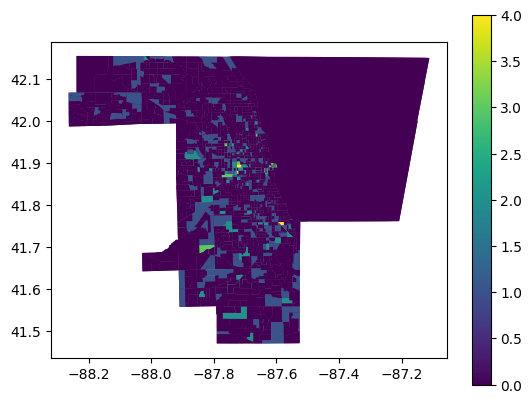

In [22]:
gdf_semi[gdf_semi['year']==2015].plot('deaths', legend=True)


### store gdf


In [23]:
csv_dir = 'cook_county_gdf_semiannual.csv'
output_path = os.path.join(data_dir, csv_dir)

# Save GeoDataFrames to CSV files
gdf_semi.to_csv(output_path, index=False)